### Outlier Detection using autoencoders-Second Version
#### Edgar Acuna
#### February 2019

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
url= "c://PW-PR/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names)
yd=data['class']
Xd=data.iloc[:,0:8]

In [4]:
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
RANDOM_SEED = 101
cols_to_norm = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
scaler = MinMaxScaler()
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
data.shape

(768, 9)

In [5]:
train_x, test_x = train_test_split(data, test_size=.2, random_state=RANDOM_SEED)
train_x = train_x[train_x['class']==1] # no diabetes
train_x = train_x.drop(['class'], axis=1) #drop the class column
test_y = test_x['class'] #save the class column for the test set
test_x = test_x.drop(['class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values
train_x.shape

(397, 8)

In [6]:
# No of Neurons in each Layer 
nb_epoch = 20
batch_size = 50
input_dim = train_x.shape[1] #num of columns, 8
encoding_dim = 4
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 24        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [7]:
import datetime
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(train_x,train_x,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - 
t_ini).total_seconds()))



df_history = pd.DataFrame(history.history) 

Time to run the model: 1.354858 Sec.


In [8]:
predictions = autoencoder.predict(test_x)
test_x.shape

(154, 8)

In [9]:
mse = np.mean(np.power(test_x- predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': test_y}, index=test_y.index)
df_error.describe()

,Label,reconstruction_error
count,154.000000,154.000000
mean,1.331169,0.117199
std,0.472169,0.047044
min,1.000000,0.042042
25%,1.000000,0.085762
50%,1.000000,0.110278
75%,2.000000,0.140163
max,2.000000,0.374143


In [10]:
dfOutliers = df_error.index[df_error.reconstruction_error > .12].tolist()
len(dfOutliers)

60

In [11]:
print(dfOutliers)

[748, 42, 485, 445, 427, 428, 123, 616, 648, 227, 31, 689, 715, 267, 228, 351, 274, 660, 56, 646, 517, 138, 621, 413, 410, 323, 339, 128, 417, 100, 295, 345, 364, 675, 731, 670, 588, 669, 708, 691, 728, 420, 582, 614, 36, 258, 84, 24, 755, 459, 509, 317, 319, 12, 612, 2, 187, 603, 672, 298]


In [12]:
y=df_error['reconstruction_error'].tolist()
x = df_error.index.tolist()

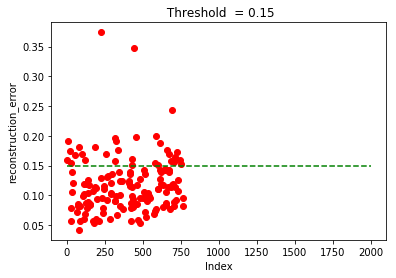

In [13]:
thresh=0.15
plt.plot(x, y, 'ro')
plt.ylabel('reconstruction_error')
plt.xlabel('Index')
plt.title(' Threshold  = ' +str(thresh))
plt.plot([0,2000],[thresh,thresh],"g--")